<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

## 03 Preprocessing & Modelling

> SG-DSI-41 Group 01: Daryl Chia, Germaine Choo, Sharifah Nurulhuda, Tan Wei Chiong

---

## 01 Import Libraries

In [1]:
# Import libraries, modules, and functions:
import os
import joblib
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

## 02 Load & Check Data

### 02.01 Load & Check Data

In [2]:
# Load data:
comments = pd.read_csv('../data/comments_2.csv')

# Increase data frame column width:
pd.set_option('max_colwidth', 400)

# Check data:
print(comments.shape)
comments.head()

(84244, 6)


,thread_id,comment_id,comment_text,comment_length,comment_word_count,generation_z
0,18ay2s2,kc10fzs,Watch their kid just become like an accountant,46,8,0
1,18ay2s2,kc1bowr,Can you imagine the bragging rights at school Random kid My dad is a doctor The kid My grandpa was KURT COBAIN Random kid Oh yeah well my mom knows an influencer The kid My other grandpa is TONY HAWK silence,252,86,0
2,18ay2s2,kc12zpc,They both look like their dads,30,6,0
3,18ay2s2,kc11j9m,The Sacred One shall be birthed anew,36,7,0
4,18ay2s2,kc0zrs8,The world is so small yet so big at the same time,49,12,0


### 02.02 Check Data Information & for Null Values

In [3]:
# Check data info:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84244 entries, 0 to 84243
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   thread_id           84244 non-null  object
 1   comment_id          84244 non-null  object
 2   comment_text        84243 non-null  object
 3   comment_length      84244 non-null  int64 
 4   comment_word_count  84244 non-null  int64 
 5   generation_z        84244 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [4]:
# Check data for null values:
comments.isnull().sum()

thread_id             0
comment_id            0
comment_text          1
comment_length        0
comment_word_count    0
generation_z          0
dtype: int64

In [5]:
comments[comments['comment_text'].isnull()]

,thread_id,comment_id,comment_text,comment_length,comment_word_count,generation_z
13481,184nhro,kazb3cv,NaN,4,1,0


In [6]:
# Drop rows with null values in column 'comment_text':
comments = comments[comments['comment_text'].notnull()]
comments.shape[0]

84243

> - 1 null comment observed and removed. This was due to the loading process recognizing the string 'None' as a null value.

## 03 Preprocess Data

### 03.01 Undersample Majority Class Data

In [7]:
# Define X and y:
X = comments[['comment_text']]
y = comments['generation_z']

In [8]:
# Check distribution of y target classes:
print(y.value_counts())
print(y.value_counts(normalize=True))

generation_z
0    47305
1    36938
Name: count, dtype: int64
generation_z
0    0.56153
1    0.43847
Name: proportion, dtype: float64


In [9]:
# Instantiate random under sampler:
rus = RandomUnderSampler(random_state=42)

In [10]:
# Fit and resample X and y:
X_rus, y_rus = rus.fit_resample(X, y)

In [11]:
# Check distribution of y_rus target classes:
print(y_rus.value_counts())
print(y_rus.value_counts(normalize=True))

generation_z
0    36938
1    36938
Name: count, dtype: int64
generation_z
0    0.5
1    0.5
Name: proportion, dtype: float64


In [12]:
# Reset X_rus data frame index:
X_rus.reset_index(drop=True, inplace=True)

# Reset y_rus series index:
y_rus.reset_index(drop=True, inplace=True)

> - The majority class where column 'generation_z' = 0 was randomly undersampled to ensure class balance in the training and testing sets.

### 03.02 Stem Comment Words

In [13]:
# Define stemmer function:
def stemmer(row):
    '''Applies `PorterStemmer()` to each token in a document.
    '''
    # initializes PorterStemmer object
    stem = PorterStemmer()

    # extracts document
    document = row['comment_text']

    # splits document up into tokens using RegexpTokenizer
    re_tokenizer = RegexpTokenizer(pattern=r"(?u)\b(?:\w\w+|i|I)(?:[\'\'\′\ʼ](?:s|t|m|re|ve|d|ll))?\b")
    lst_of_tokens = re_tokenizer.tokenize(document)

    # initialize return value
    stemmed_document = ''

    # applies PorterStemmer to the list of tokens
    for token in lst_of_tokens:
        stemmed_document += f'{stem.stem(token)} '
    
    return stemmed_document

In [14]:
# Stem comments:
X_rus['comment_text'] = X_rus.apply(stemmer,axis=1)
X_rus.head()

,comment_text
0,someon need to steal op' freakin kidney for not know charli the unicorn
1,who said they don't do that point out that tiktok is like design to all of thi doesn't mean you'r assert that compani aren't guilti of the same thing
2,thi happen in also
3,he probabl contribut travel and have drink and meal with the company' money so it' busi expens that can reduc the company' tax burden
4,i doubt ani of these peopl know they are now on reddit


> - Comment words are stemmed to feature root words as much as possible for better classifier fitting and prediction.

### 03.03 Perform Train Test Split

In [15]:
# Perform train test split on data:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, random_state=42, stratify=y_rus)

### 03.04 Word Vectorize Comments

Word Vectorizer 1

In [16]:
# Instantiate 'TF-IDF' vectorizer 1:
tvec = TfidfVectorizer(stop_words='english',
                       token_pattern=r"(?u)\b(?:\w\w+|i|I)(?:[\'\’\′\ʼ](?:s|t|m|re|ve|d|ll))?\b",
                       ngram_range=(1, 3),
                       max_df=0.9,
                       min_df=2,
                       max_features=50000,
                       smooth_idf=True)

In [17]:
# Fit vectorizer 1 with corpus X_train and transform X_train:
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['comment_text']).todense(),
                            columns=tvec.get_feature_names_out())
X_train_tvec.shape

(55407, 50000)

In [18]:
# Transform corpus X_test with vectorizer 1:
X_test_tvec = pd.DataFrame(tvec.transform(X_test['comment_text']).todense(),
                            columns=tvec.get_feature_names_out())
X_test_tvec.shape

(18469, 50000)

Word Vectorizer 2

In [19]:
# Instantiate 'TF-IDF' vectorizer 2:
tvec_2 = TfidfVectorizer(stop_words='english',
                       token_pattern=r"(?u)\b(?:\w\w+|i|I)(?:[\'\’\′\ʼ](?:s|t|m|re|ve|d|ll))?\b",
                       ngram_range=(1, 3),
                       max_df=0.9,
                       min_df=2,
                       max_features=25000,
                       smooth_idf=True)

In [20]:
# Fit vectorizer 2 with corpus X_train and transform X_train:
X_train_tvec_2 = pd.DataFrame(tvec_2.fit_transform(X_train['comment_text']).todense(),
                            columns=tvec_2.get_feature_names_out())
X_train_tvec_2.shape

(55407, 25000)

In [21]:
# Transform corpus X_test with vectorizer 1:
X_test_tvec_2 = pd.DataFrame(tvec_2.transform(X_test['comment_text']).todense(),
                            columns=tvec_2.get_feature_names_out())
X_test_tvec_2.shape

(18469, 25000)

## 04 Fit Classifier Models

### 04.01 Bernoulli Naive Bayes

Word Vectorizer 1

In [22]:
# Instantiate bernoulli naive bayes classifier (tvec 1):
bnb = BernoulliNB()

In [23]:
# Fit bernoulli naive bayes model with training set (tvec 1):
model_bnb = bnb.fit(X_train_tvec, y_train)

Word Vectorizer 2

In [24]:
# Instantiate bernoulli naive bayes classifier (tvec 2):
bnb_2 = BernoulliNB()

In [25]:
# Fit bernoulli naive bayes model with training set (tvec 2):
model_bnb_2 = bnb_2.fit(X_train_tvec_2, y_train)

### 04.02 Multinomial Naive Bayes

Word Vectorizer 1

In [26]:
# Instantiate multinommial naive bayes classifier (tvec 1):
mnb = MultinomialNB()

In [27]:
# Fit multinomial naive bayes model with training set (tvec 1):
model_mnb = mnb.fit(X_train_tvec, y_train)

Word Vectorizer 2

In [28]:
# Instantiate multinommial naive bayes classifier (tvec 2):
mnb_2 = MultinomialNB()

In [29]:
# Fit multinomial naive bayes model with training set (tvec 2):
model_mnb_2 = mnb_2.fit(X_train_tvec_2, y_train)

### 04.03 Logistic Regression

In [30]:
# Instantiate logistic regression models:
# LASSO (l1), α=1:
lr_l1_1 = LogisticRegression(penalty='l1', C=1, random_state=42, solver='liblinear')
# LASSO (l1), α=10:
lr_l1_10 = LogisticRegression(penalty='l1', C=0.1, random_state=42, solver='liblinear')
# Ridge (l2), α=1:
lr_l2_1 = LogisticRegression(penalty='l2', C=1, random_state=42, solver='liblinear')
# Ridge (l2), α=10:
lr_l2_10 = LogisticRegression(penalty='l2', C=0.1, random_state=42, solver='liblinear')

In [31]:
# Fit logistic regression models with training set (tvec 1):
# LASSO (l1), α=1:
model_lr_l1_1 = lr_l1_1.fit(X_train_tvec, y_train)
# LASSO (l1), α=10:
model_lr_l1_10 = lr_l1_10.fit(X_train_tvec, y_train)
# Ridge (l2), α=1:
model_lr_l2_1 = lr_l2_1.fit(X_train_tvec, y_train)
# Ridge (l2), α=10:
model_lr_l2_10 = lr_l2_10.fit(X_train_tvec, y_train)

## 05 Evaluate Classifier Models

### 04.01 Bernoulli Naive Bayes

Word Vectorizer 1

In [32]:
# Evaluate bernoulli naive bayes model with training set (tvec 1):
model_bnb.score(X_train_tvec, y_train)

0.7270020033569765

In [33]:
# Evaluate bernoulli naive bayes model with testing set (tvec 1):
model_bnb.score(X_test_tvec, y_test)

0.6941902647679896

In [34]:
# Get bernoulli naive bayes model testing predictions (tvec 1):
y_pred_bnb = model_bnb.predict(X_test_tvec)

# Get confusion matrix values:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bnb).ravel()
cm = confusion_matrix(y_test, y_pred_bnb)

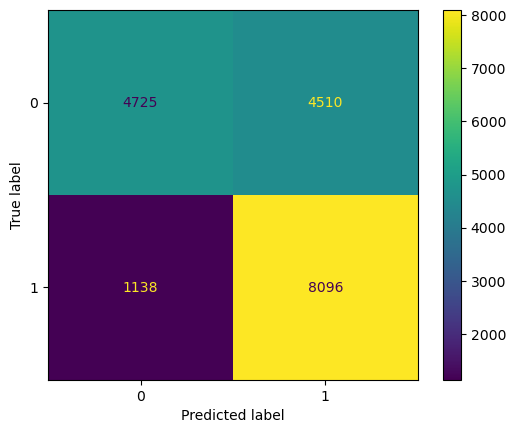

In [35]:
# Plot confusion matrix (tvec 1):
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_bnb.classes_)
disp.plot()

In [36]:
# Print classification report (tvec 1):
print(classification_report(y_test, y_pred_bnb))

              precision    recall  f1-score   support

           0       0.81      0.51      0.63      9235
           1       0.64      0.88      0.74      9234

    accuracy                           0.69     18469
   macro avg       0.72      0.69      0.68     18469
weighted avg       0.72      0.69      0.68     18469



Word Vectorizer 2

In [37]:
# Evaluate bernoulli naive bayes model with training set (tvec 2):
model_bnb_2.score(X_train_tvec_2, y_train)

0.712039994946487

In [38]:
# Evaluate bernoulli naive bayes model with testing set (tvec 2):
model_bnb_2.score(X_test_tvec_2, y_test)

0.6950565812983919

In [39]:
# Get bernoulli naive bayes model testing predictions (tvec 2):
y_pred_bnb_2 = model_bnb_2.predict(X_test_tvec_2)

# Get confusion matrix values:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bnb_2).ravel()
cm = confusion_matrix(y_test, y_pred_bnb_2)

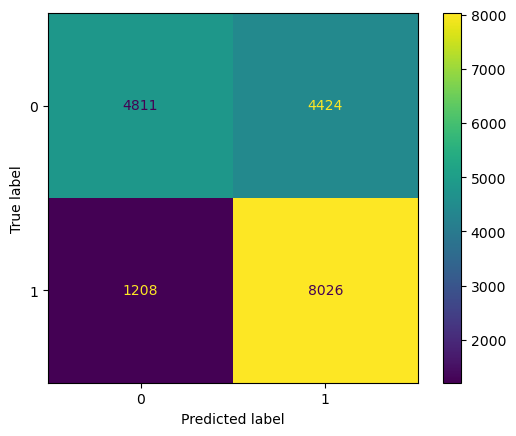

In [40]:
# Plot confusion matrix (tvec 2):
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_bnb.classes_)
disp.plot()

In [41]:
# Print classification report (tvec 2):
print(classification_report(y_test, y_pred_bnb_2))

              precision    recall  f1-score   support

           0       0.80      0.52      0.63      9235
           1       0.64      0.87      0.74      9234

    accuracy                           0.70     18469
   macro avg       0.72      0.70      0.69     18469
weighted avg       0.72      0.70      0.69     18469



### 04.02 Multinomial Naive Bayes

Word Vectorizer 1

In [42]:
# Evaluate multinomial naive bayes model with training set (tvec 1):
model_mnb.score(X_train_tvec, y_train)

0.8387748840399227

In [43]:
# Evaluate multinomial naive bayes model (tvec 1) with testing set (tvec 1):
model_mnb.score(X_test_tvec, y_test)

0.7618712437056689

In [44]:
# Get bernoulli naive bayes model (tvec 1) testing predictions (tvec 1):
y_pred_mnb = model_mnb.predict(X_test_tvec)

# Get confusion matrix values:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_mnb).ravel()
cm = confusion_matrix(y_test, y_pred_mnb)

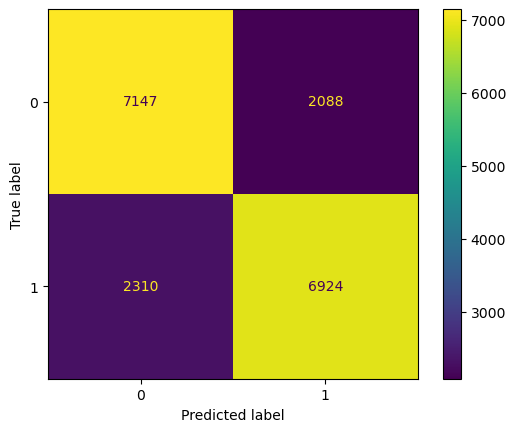

In [45]:
# Plot confusion matrix (tvec 1) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_mnb.classes_)
disp.plot()

In [46]:
# Print classification report (tvec 1):
print(classification_report(y_test, y_pred_mnb))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76      9235
           1       0.77      0.75      0.76      9234

    accuracy                           0.76     18469
   macro avg       0.76      0.76      0.76     18469
weighted avg       0.76      0.76      0.76     18469



Word Vectorizer 2

In [47]:
# Evaluate multinomial naive bayes model with training set (tvec 1):
model_mnb_2.score(X_train_tvec_2, y_train)

0.8122078437742524

In [48]:
# Evaluate multinomial naive bayes model (tvec 1) with testing set (tvec 1):
model_mnb_2.score(X_test_tvec_2, y_test)

0.7578645297525584

In [49]:
# Get bernoulli naive bayes model (tvec 1) testing predictions (tvec 1):
y_pred_mnb_2 = model_mnb_2.predict(X_test_tvec_2)

# Get confusion matrix values:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_mnb_2).ravel()
cm = confusion_matrix(y_test, y_pred_mnb_2)

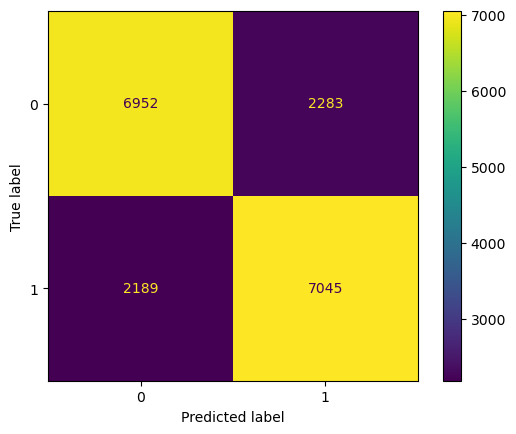

In [50]:
# Plot confusion matrix (tvec 1) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_mnb_2.classes_)
disp.plot()

In [51]:
# Print classification report (tvec 1):
print(classification_report(y_test, y_pred_mnb_2))

              precision    recall  f1-score   support

           0       0.76      0.75      0.76      9235
           1       0.76      0.76      0.76      9234

    accuracy                           0.76     18469
   macro avg       0.76      0.76      0.76     18469
weighted avg       0.76      0.76      0.76     18469



### 04.03 Logistic Regression

In [52]:
# Evaluate logistic regression models with training set:
# LASSO (l1), α=1:
score_train_l1_1 = model_lr_l1_1.score(X_train_tvec, y_train)
# LASSO (l1), α=10:
score_train_l1_10 = model_lr_l1_10.score(X_train_tvec, y_train)
# Ridge (l2), α=1:
score_train_l2_1 = model_lr_l2_1.score(X_train_tvec, y_train)
# Ridge (l2), α=10:
score_train_l2_10 = model_lr_l2_10.score(X_train_tvec, y_train)

In [53]:
# Print training scores:
print('Logit reg training scores:')
# LASSO (l1), α=1:
print(f"LASSO (l1), α=1: {round(score_train_l1_1, 2)}")
# LASSO (l1), α=10:
print(f"LASSO (l1), α=10: {round(score_train_l1_10, 2)}")
# Ridge (l2), α=1:
print(f"Ridge (l2), α=1: {round(score_train_l2_1, 2)}")
# Ridge (l2), α=10:
print(f"Ridge (l2), α=10: {round(score_train_l2_10, 2)}")

Logit reg training scores:
LASSO (l1), α=1: 0.79
LASSO (l1), α=10: 0.69
Ridge (l2), α=1: 0.85
Ridge (l2), α=10: 0.77


In [54]:
# Evaluate logistic regression models with testing set:
# LASSO (l1), α=1:
score_test_l1_1 = model_lr_l1_1.score(X_test_tvec, y_test)
# LASSO (l1), α=10:
score_test_l1_10 = model_lr_l1_10.score(X_test_tvec, y_test)
# Ridge (l2), α=1:
score_test_l2_1 = model_lr_l2_1.score(X_test_tvec, y_test)
# Ridge (l2), α=10:
score_test_l2_10 = model_lr_l2_10.score(X_test_tvec, y_test)

In [55]:
# Print testing scores:
print('Logit reg testing scores:')
# LASSO (l1), α=1:
print(f"LASSO (l1), α=1: {round(score_test_l1_1, 4)}")
# LASSO (l1), α=10:
print(f"LASSO (l1), α=10: {round(score_test_l1_10, 4)}")
# Ridge (l2), α=1:
print(f"Ridge (l2), α=1 {round(score_test_l2_1, 4)}")
# Ridge (l2), α=10:
print(f"Ridge (l2), α=10: {round(score_test_l2_10, 4)}")

Logit reg testing scores:
LASSO (l1), α=1: 0.7525
LASSO (l1), α=10: 0.6849
Ridge (l2), α=1 0.7621
Ridge (l2), α=10: 0.7396


In [56]:
# Get best logistic regression model testing predictions:
y_pred_lr = model_lr_l2_1.predict(X_test_tvec)

# Get confusion matrix values:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()
cm = confusion_matrix(y_test, y_pred_lr)

> **Logistic Regression with Ridge (l2) regularization and α=1** is chosen as the best model, given it has the highest test score.

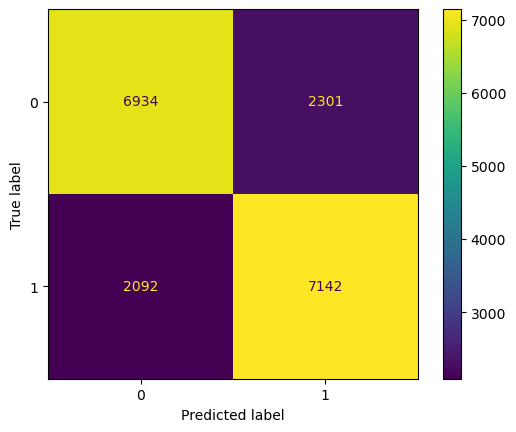

In [57]:
# Plot confusion matrix:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_lr_l2_1.classes_)
disp.plot()

In [58]:
# Print classification report:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      9235
           1       0.76      0.77      0.76      9234

    accuracy                           0.76     18469
   macro avg       0.76      0.76      0.76     18469
weighted avg       0.76      0.76      0.76     18469



### 04.04 Summary of Results

> |   |**Classifier**|**TF-IDF Vectorizer**|**Regularization**|**Penalty Term ($α$)**|**Accuracy (Training Set)**|**Accuracy (Testing Set)**|
> |---|---|---|---|---|---|---|
> |1|Bernoulli Naive Bayes |Vectorizer 1 (50k max_features)|-|-|0.73|0.69|
> |2|Bernoulli Naive Bayes |Vectorizer 2 (25k max_features)|-|-|0.71|0.70|
> |3|Multinomial Naive Bayes |Vectorizer 1 (50k max_features)|-|-|0.84|0.76|
> |4|Multinomial Naive Bayes |Vectorizer 2 (25k max_features)|-|-|0.81|0.76|
> |5|Logistic Regression|Vectorizer 1 (50k max_features)|LASSO (l1)|1|0.79|0.75|
> |6|Logistic Regression|Vectorizer 1 (50k max_features)|LASSO (l1)|10|0.69|0.68|
> |7|Logistic Regression|Vectorizer 1 (50k max_features)|Ridge (l2)|1|0.85|0.76|
> |8|Logistic Regression|Vectorizer 1 (50k max_features)|Ridge (l2)|10|0.77|0.74|

## 05 Export Fitted Word Vectorizer and Logistic Regression Model

In [59]:
# Export fitted 'TF-IDF' vectorizer for demonstration:
joblib.dump(tvec, './tvec.pkl')

['./tvec.pkl']

In [60]:
# Export chosen fitted classifier model for demonstration:
joblib.dump(model_lr_l2_1, './model_lr.pkl')

['./model_lr.pkl']